### Part B. Neural Network vs. Perceptron In this part, you apply a 3-layer Neural Network on a synthetically generated data to compare its performance with Perceptron. Here, we are looking for your explanation about the differences between perceptron and NN that leads to different results.

### Question 2 [Neural Network’s Decision Boundary]


#### Importing required libraries

In [1]:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

Warning message:
"package 'mvtnorm' was built under R version 3.6.2"Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'reshape2' was built under R version 3.6.3"

1. Load Task2B_train.csv and Task2B_test.csv sets, plot the training data with classes are marked with different colors, and attach the plot to your PDF report.


In [2]:
tr_data = read.csv('Task2B_train.csv')
te_data = read.csv('Task2B_test.csv')
head(tr_data,2)
head(te_data,2)

x1,x2,y
-0.4365731,0.3199448,0
-0.3351625,-0.6077436,1


x1,x2,y
0.4973951,-0.5492695,1
0.2139925,0.6141635,0


In [3]:
# removing all NA rows
train_data_notnull = tr_data[complete.cases(tr_data), ]
test_data_notnull = te_data[complete.cases(te_data), ]

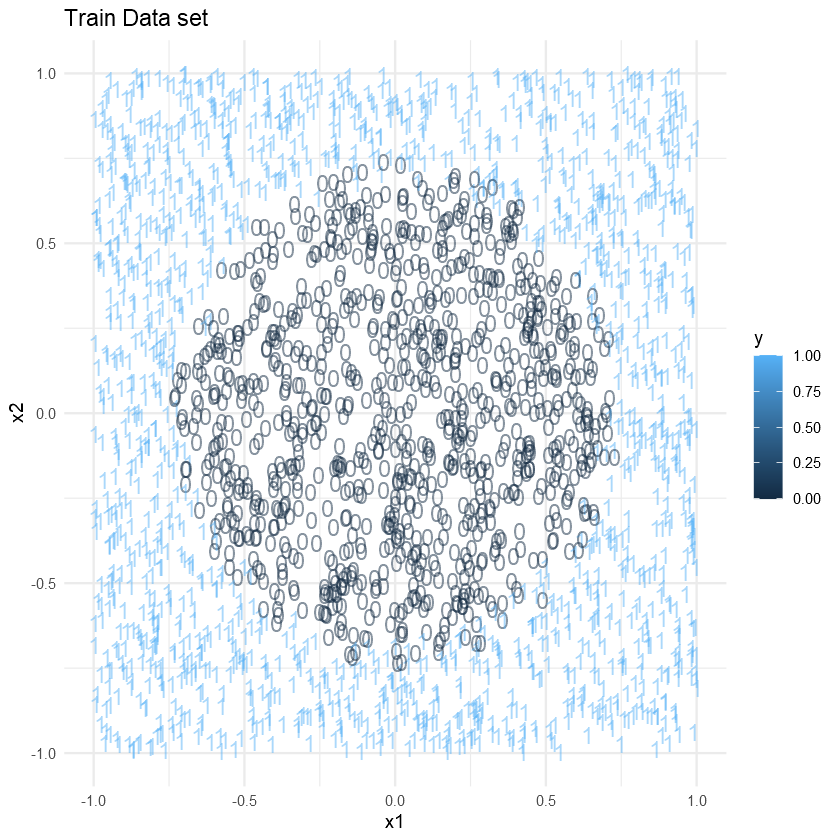

In [4]:
## Take a look at the train data set
ggplot(data=train_data_notnull, aes(x=x1, y=x2, color=y, label=ifelse(y==0, 0, 1))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Train Data set') +
    theme_minimal()

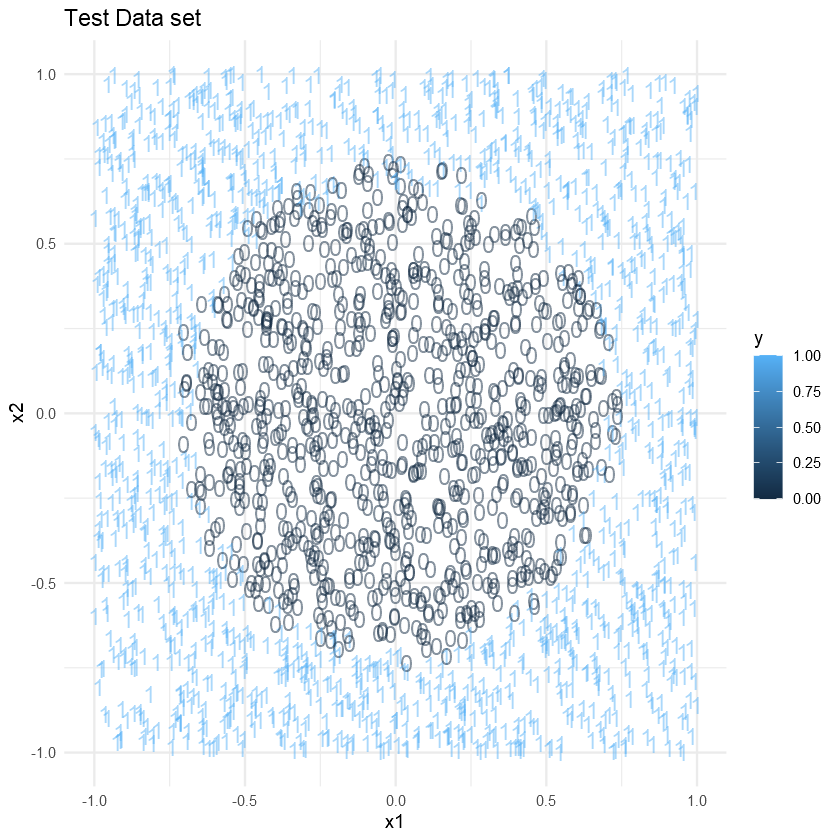

In [5]:
## Take a look at the test data set
ggplot(data=test_data_notnull, aes(x=x1, y=x2, color=y, label=ifelse(y==0, 0, 1))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Test Data set') +
    theme_minimal()

We can see that both train and test data is non-linearly classified. The circular region represents one class and outer region other class <br>
<br>

2. Train two perceptron models on the loaded training data by setting the learning rates η to .01 and .09 respectively, using a code from Activity 3.1. Calculate the test errors of two models and find the best η and its corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report. Hint: Note that you must remove NA records from the datasets (using “complete.cases()’ function). You may also choose to change the labels from [0, 1] to [-1, +1] for your convenience. If you decided to use the code from Activity 3.1, you may need to change some initial settings (e.g., epsilon and tau.max). Finally, remember 3 that perceptron is sensitive to initial weights. Therefore, we recommend to run your code a few times with different initial weights.

#### Getting data ready for perceptron

In [6]:
head(train_data_notnull,2)
head(test_data_notnull,2)

x1,x2,y
-0.4365731,0.3199448,0
-0.3351625,-0.6077436,1


x1,x2,y
0.4973951,-0.5492695,1
0.2139925,0.6141635,0


Creating two new dataframes for train and test data, to be exclusively used for Perceptron Model

In [7]:
train_data = train_data_notnull[,]
test_data = test_data_notnull[,]

Chaning the target labels to +1 and -1 from 1 and 0, respectively

In [8]:
train_data$y = ifelse(train_data$y==0,-1,+1)
test_data$y = ifelse(test_data$y==0,-1,+1)

In [9]:
head(train_data,2)

x1,x2,y
-0.4365731,0.3199448,-1
-0.3351625,-0.6077436,1


In [10]:
head(test_data,2)

x1,x2,y
0.4973951,-0.5492695,1
0.2139925,0.6141635,-1


#### Split data to get data and labels for both test and train data

In [11]:
train.data <- train_data[,-3]
test.data <- test_data[,-3]
train.label <- train_data[,3]
test.label <- test_data[,3]

In [12]:
head(train.data,2)
head(test.data,2)
head(train.label,2)
head(test.label,2)

x1,x2
-0.4365731,0.3199448
-0.3351625,-0.6077436


x1,x2
0.4973951,-0.5492695
0.2139925,0.6141635


[1] -1  1

[1]  1 -1

2. Train two perceptron models on the loaded training data by setting the learning rates η to .01 and .09 respectively, using a code from Activity 3.1. Calculate the test errors of two models and find the best η and its corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.


Before implementing Perceptron Model we need to define some functions.

#### The following structure helps us to have functions with multiple outputs

In [13]:
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
  args <- as.list(match.call())
  args <- args[-c(1:2,length(args))]
  length(value) <- length(args)
  for(i in seq(along=args)) {
    a <- args[[i]]
    if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
  }
  x
}

#### Function is used to calculate the Training error rate after each weight updation

In [14]:
error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){  # checks if length of our labels is 2, as we just have two classes
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

#### Function predicts class as +1 and -1 based on the value of Input*Weight <br>
* If input multiplies by respective weight gives us a value greater than 0, then we assign it to class +1 otherwise class -1

In [15]:
## prediction
perceptron.predict <- function(Phi, W){
  return(ifelse(Phi%*%W>=0, +1, -1))
}

#### Function checks if there is a misclassification <br>
* Since weight updation takes place only for misclassifications, this function is used to check for misclassification.
* we multiply our predicted output with actual value.
* Both have be either +1 or -1 for correct classification. When there is a misclassification the multiplication of both will result in a negative number, hence the condition " <0 ".

In [16]:
## is it a misclassification? if yes, update the weight vector
is.a.miss <- function(Phi, W, T1){
  return((W%*%Phi)*T1<0)
}

### Perceptron Training model - Returns updated weights <br>

* The purpose of this bulid model is to find the optimum weights by updating the model parameters Phi. 
* Model is terminated based on the number of iterations we want to conduct i.e. tau OR if our loss claculated after each iteration falls below the already set threshold.
* The build returns the final updated weights.

In [25]:
####################### PERCEPTRON #######################
## Perceptron Build function
perceptron.build <- function(X1, T1, eta=0.01, epsilon=0.001, tau.max=100, plotting=FALSE){
  if (length(unique(T1))!=2){
    stop("Perceptron: The input data is not a binary classification problem.")
  }
  if (all(sort(unique(T1)) != c(-1, 1))) {
    stop("Perceptron: The labels are not (-1, +1).")
  }
  
  N1 <- nrow(X1)
  Phi <- as.matrix(cbind(1, X1)) # add a column of 1 as phi_0

  W <- matrix(NA,nrow=tau.max, ncol=ncol(Phi)) # Empty Weight vector
  W[1,] <- 2*runif(ncol(Phi))-1 # Random initial values for weight vector
  error.rec <- matrix(NA,nrow=tau.max, ncol=1) # Placeholder for errors
  error.rec[1] <- error.rate(perceptron.predict(Phi, W[1,]), T1) # record error for initial weights
  tau <- 1 # iteration counter 
  terminate <- FALSE # termination status
  
  while(!terminate){
    # resuffling train data and associated labels:
    indx <- sample(1:N1, replace = FALSE)
    Phi <- Phi[indx,]
    T1 <- T1[indx]
    
    for (i in 1:N1){
      if (tau >= tau.max) {break}
      # look for missclassified samples
      if (is.a.miss(Phi[i,], W[tau,], T1[i])){
        tau <- tau +1                                 # update tau counter
        W[tau,] <- W[tau-1,] + eta * Phi[i,] * T1[i]  # update the weights
        error.rec[tau] <- error.rate(perceptron.predict(Phi, W[tau,]), T1)# update the records
        eta = eta * 0.99                                 # decrease eta
      } 
    }
    
    # recalculate termination conditions
    terminate <- tau >= tau.max | (abs(error.rec[tau] - error.rec[tau-1]) <= epsilon )
    
  }
  if (plotting){
    plot(error.rec[complete.cases(error.rec),], xlab = 'tau', ylab = 'error', main = 'Perceptron')
  }
  W <- W[complete.cases(W),]  # cut the empty part of the matrix (when the loop stops before tau == tau.max)
  return(W[nrow(W),])         # return the last wight vector
}

### PERCEPTRON MODELS <br>

* Now we will use the updated weights we got from the build function on test data and calculate W*Phi for each input data point.
* predict function that we described earlier is used to calculate the predictions and then error is calculated for the model.
* It is recommended to run the build many times, as weights get generated initially randomly and may affect our final test error

### Perceptron Model 1 - Learning rate = 0.01

In [38]:
W = perceptron.build(train.data,train.label,eta=0.01, epsilon=0.001, tau.max=500, plotting=FALSE)
test.Phi_0.01 <- as.matrix(cbind(1, test.data)) # adding bias column
prediction_0.01 = perceptron.predict(test.Phi_0.01,W)  # predicting for each input in Phi
error.percentage_0.01 = 1-(sum(prediction_0.01==test.label)/nrow(prediction_0.01)) # calulating error rate
cat("Error percentage on Train data with Perceptron Learning rate 0.01 is ",error.percentage_0.01,'%')

Error percentage on Train data with Perceptron Learning rate 0.01 is  0.5344 %

### Perceptron Model 2 - Learning rate = 0.09

In [42]:
W = perceptron.build(train.data,train.label,eta=0.09, epsilon=0.001, tau.max=500, plotting=FALSE)
test.Phi_0.09 <- as.matrix(cbind(1, test.data))  # adding bias column
prediction_0.09 = perceptron.predict(test.Phi_0.09,W) # # predicting for each input in Phi
error.percentage_0.09 = 1-(sum(prediction_0.09==test.label)/nrow(prediction_0.09)) # calulating error rate
cat("Error percentage on Train data with Perceptron Learning rate 0.09 is ",error.percentage_0.09,'%')

Error percentage on Train data with Perceptron Learning rate 0.09 is  0.514 %

**We can conclude that the best model is Perceptron Model 2 with Learning rate = 0.09** <br>

<br>**Plotting Test Data with points colored as our predictions from the Perceptron Model 2**

In [43]:
plot_data = test.data[,]
plot_data$prediction_0.09 = prediction_0.09
head(plot_data,3)

x1,x2,prediction_0.09
0.4973951,-0.5492695,-1
0.2139925,0.6141635,1
-0.4656182,0.5093878,1


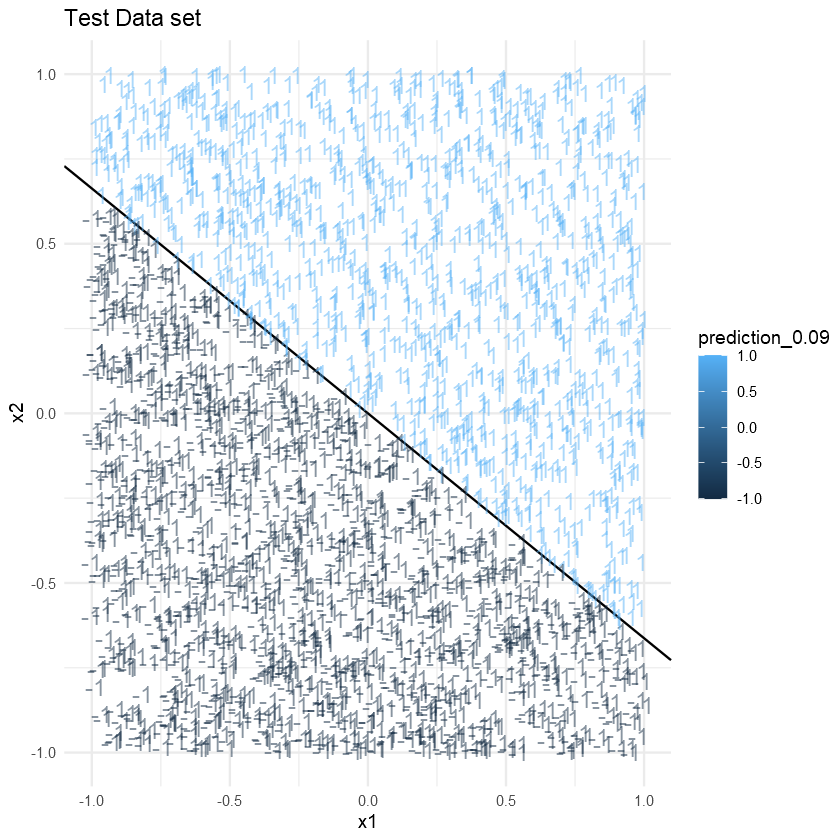

In [44]:
#plotting test data with labels derived from prediction_0.09
ggplot(data=plot_data, aes(x=x1, y=x2, color=prediction_0.09, label=ifelse(prediction_0.09==-1, -1, +1)))+geom_abline(intercept=W[1], slope=-W[2]/W[3])+
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Test Data set') +
    theme_minimal()

* From the graph we can visualise that our perceptron has linearly separated our data into two classes <br>
<br>

3. For each combination of K (i.e, number of units in the hidden layer) in {5, 10, 15, …, 100} and µ (learning rate) in {0.01, 0.09}, run the 3-layer Neural Network given to you in Activity 5.1 and record testing error for each of them (40 models will be developed, based on all possible combinations). Plot the error for µ 0.01 and 0.09 vs K (one line for µ 0.01 and another line for µ 0.09 in a plot) and attach it to your PDF report. Based on this plot, find the best combination of K and µ and the corresponding model, then plot the test data while the points are colored with their estimated class labels using the best model that you have selected; attach the plot to your PDF report.

* Below we have defined few functions that will be used in developing our 3-Layer NN model

In [45]:
## the activation function (tanh here)
h <- function(z) { #activation function (sigmoid here)
  return ((exp(z)-exp(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function (tanh here)
h.d <- function(z) {
  return (1-(h(z))^2)
}
## Class Probabilities
class.prob <- function(X, W1, W2, b1, b2){
  a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
  a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
  return (a3)
}
## prediction
nn.predict <- function(X, W1, W2, b1, b2, threshold=0){
  return (ifelse(class.prob(X, W1, W2, b1, b2)>=threshold, 1, -1))
}

## Accuracy
accuracy <- function(Y, T){
    return (sum(Y==T)/length(T)*100)
}

#### Function is used to calculate the error rate 

In [46]:
error.rate <- function(Y1, T1){
  if (length(Y1)!=length(T1)){
    stop('error.rate: size of true lables and predicted labels mismatch')
  }
  return (sum(T1!=Y1)/length(T1))
}

#### Feedforward Step

* Feed forward step takes each N-dimensional input data point and multiplies each dimension with the corresponding weights.
* This is then passed into the activation function, which is tanh in our case.
* These two steps will take place for both the layers.

In [47]:
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- h(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}

#### Backpropagation Step

* In backpropagation step the final output of the activation function and weights for final layer are taken as inputs.
* Derivative of the loss function is calculated at each layer.
* These derivatives are gradients and are hence used to update our weights. This in whole leads to minimizing the loss function

In [48]:
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * h.d (z2)
  return(list(d2,d3))
}

### NEURAL NET
#### NN build function

* In build model both feed forward and back propagation steps are implemenetd
* Initially we generate the weights for each layer from a uniform distribution
* The output of the build function are the final updated layer weights and their respective activation function outputs

In [49]:
nn.build <- function(K, X1, T1, plotting=FALSE, epoch.max=50, eta = 0.1, lambda = 0.01){
  # initialization
  if (plotting) {error.rec <- matrix(NA,nrow=epoch.max, ncol=1)}
  D <- nrow(X1)
  if (D!=2) {stop('nn.predict: This simple version only accepts two dimensional data.')}
  N <- ncol(X1)

  W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
  b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
  W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
  b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)

  for (epoch in 1:epoch.max){   
    ## delta vectors/matrices initialization
    W1.d <- W1 *0
    b1.d <- b1 *0
    W2.d <- W2 *0
    b2.d <- b2 *0

    for (i in 1:N){
      ## Feedforward:
      list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
      ## Backpropagation:
      list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
      ## calculate the delta values
      ### 1st layer
      W1.d <- W1.d + d2 %*% t(a1)
      b1.d <- b1.d + d2
      ### 2nd layer
      W2.d <- W2.d + d3 %*% t(a2)
      b2.d <- b2.d + d3
    }
    ## update weight vectors and matrices
    W1 <- W1 - eta * (W1.d/N + lambda*W1)
    b1 <- b1 - eta * (b1.d/N)
    W2 <- W2 - eta * (W2.d/N + lambda*W2)
    b2 <- b2 - eta * (b2.d/N)
    ## record the errors
#     if (plotting){error.rec[epoch]<- error.rate(nn.predict(X1, W1, W2, b1, b2), T1)}
  }
#   plot(error.rec, xlab = 'epoch', ylab = 'error', main = 'Neural Net')
  return(list(W1, W2, b1, b2))
}

#### Getting data ready for NN

In [50]:
## convert data and labels to transposed matrices
X1 <- t(unname(data.matrix(train.data))) 
T1 <- t(data.matrix(as.numeric(train.label))) 

X2 <- t(unname(data.matrix(test.data))) 
T2 <- t(data.matrix(as.numeric(test.label)))

### Main Loop <br>

* We will be saving both eta values in a vector, c(0.01,0.09)
* K is the number of units in the hidden layer. It is ranged from 5 to 100 with a step size of 5
* testing_error_df_0.01 and testing_error_df_0.09 dataframes are used to save erros for 0.01 and 0.09 learning rate    respectively
* nn.build function is called each time for the combination of our eta and k value.
* Earlier defined nn.predict is used to claculate the error rate for each combination

In [51]:
learning_rate = c(0.01,0.09)

# testing_error_df <- data.frame(eta=double(),K=integer(), error=double()) # empty dataset
testing_error_df_0.01 <- data.frame(eta=double(),K=integer(), error_0.01=double())
testing_error_df_0.09 <- data.frame(eta=double(),K=integer(), error_0.09=double())

for (eta in learning_rate){
    testing_error_df <- data.frame(eta=double(),K=integer(), error=double()) # empty dataset
    for (K in seq(5,100,5)){
        
        list[W1, W2, b1, b2] = nn.build(K,X1, T1, plotting = FALSE, epoch.max = 100,eta,lambda=0.01)
        
        error = error.rate(nn.predict(X2, W1, W2, b1, b2, threshold=0),T2)
        testing_error_df[nrow(testing_error_df) + 1,] = c(eta, K , error)
        
    }
    
    if (eta==0.01) {
        testing_error_df_0.01 = testing_error_df[,]
    }
    
    else {
        testing_error_df_0.09 = testing_error_df[,]

    }
}

#### Merging and Reshaping our testing error dataframes for plotting

In [52]:
testing_error_df_0.01 <- subset(testing_error_df_0.01, select = c(K, error))
names(testing_error_df_0.01) <- c('K','error_0.01')

In [53]:
testing_error_df_0.09 <- subset(testing_error_df_0.09, select = c(K, error))
names(testing_error_df_0.09) <- c('K','error_0.09')

In [54]:
error_dataframe_merged = data.frame('K'=testing_error_df_0.01$K,'error_0.01'=testing_error_df_0.01$error_0.01,'error_0.09'= testing_error_df_0.09$error_0.09)

In [55]:
head(error_dataframe_merged,2)

K,error_0.01,error_0.09
5,0.3908,0.3908
10,0.4316,0.3908


In [56]:
error_dataframe_melted=melt(error_dataframe_merged, id='K')

In [57]:
head(error_dataframe_melted,2)

K,variable,value
5,error_0.01,0.3908
10,error_0.01,0.4316


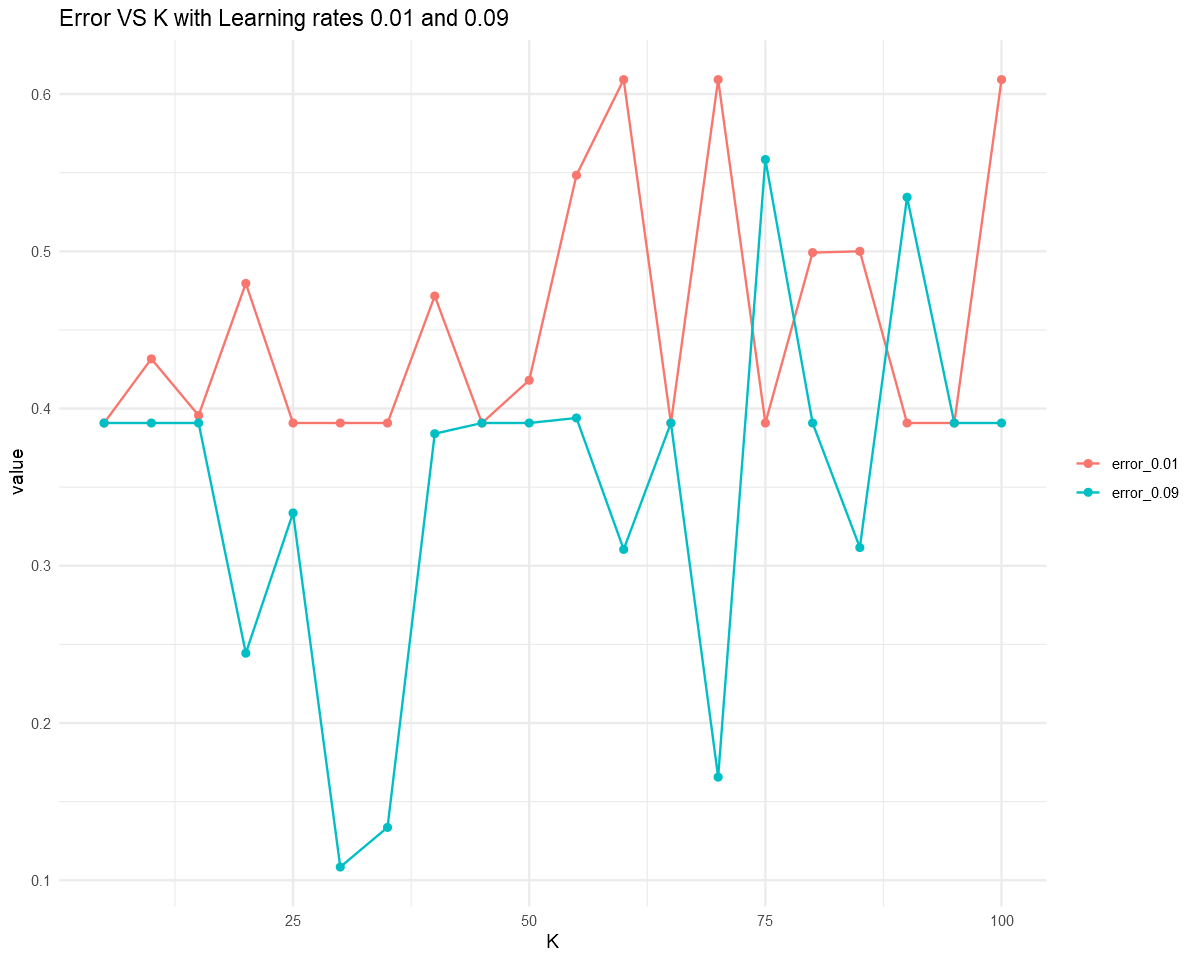

In [58]:
options(repr.plot.width=10, repr.plot.height=8)

ggplot(data=error_dataframe_melted, aes(x=K, y=value, color=variable)) + geom_line() + geom_point()+
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("Error VS K with Learning rates 0.01 and 0.09")

We can see from the plot that error reduces maximum for the model with learning rate 0.09. Let us now find the K value at which this minimum error takes place. 

In [63]:
min(testing_error_df_0.09$error_0.09)

[1] 0.1084

This minimum error is generated for the k value = 30  <br>
<br>

* So the best combination of learning rate and K is (0.09,30)
* Now let the train our model on these parameters
* We will then use nn.predict function on train data and plot the train data colored with predicted labels

In [112]:
list[W1, W2, b1, b2] = nn.build(30,X1, T1, plotting = FALSE, epoch.max = 100,eta=0.09,lambda=0.01)
predictions = t(nn.predict(X2, W1, W2, b1, b2, threshold=0))

Binding the test.data with target labels

In [125]:
test_data = cbind(test.data,t(T2))

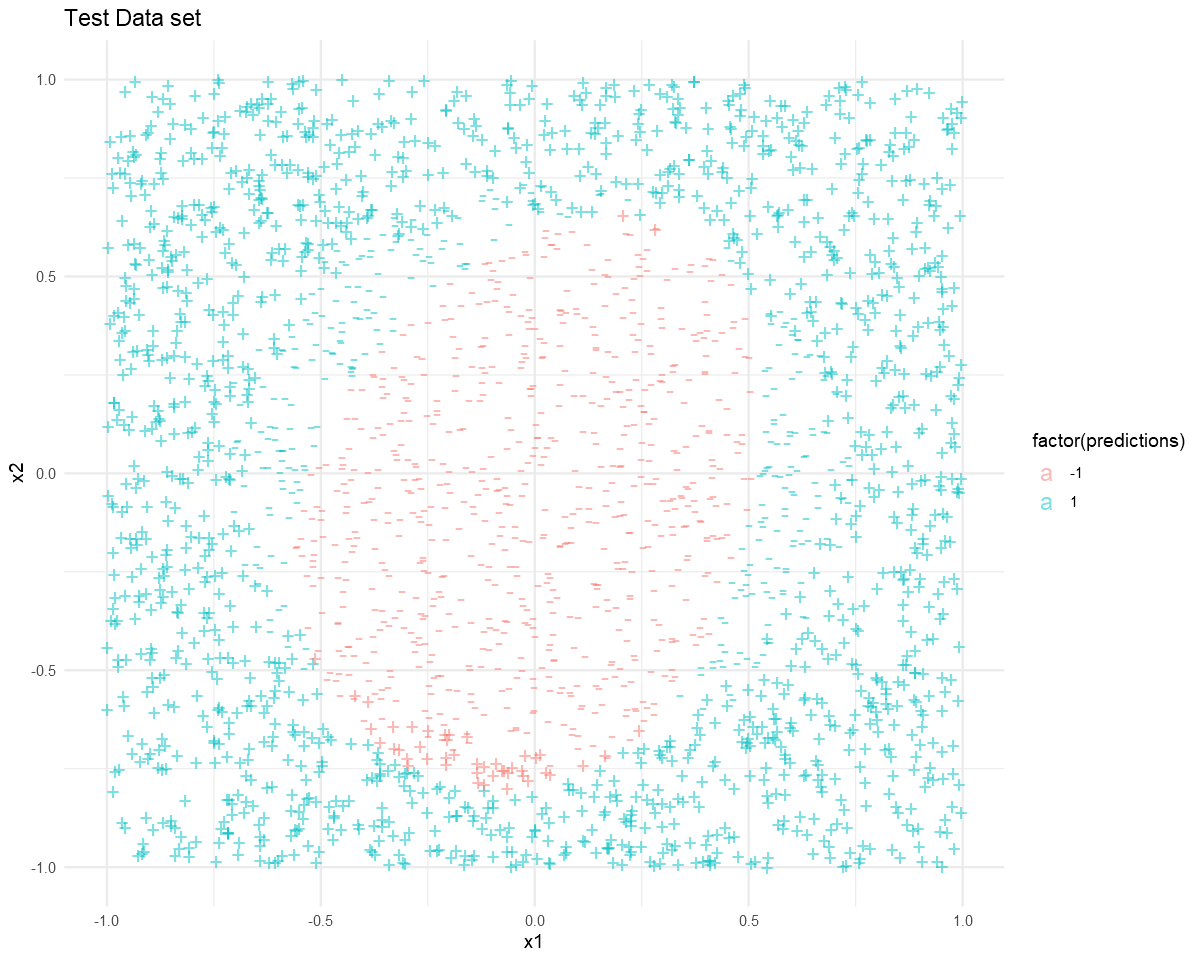

In [127]:
#plotting test data with labels derived from prediction_0.09
ggplot(data=test_data, aes(x=x1, y=x2, label=ifelse(t(T2)==1, '+', '-'), color=factor(predictions))) +
    geom_text(size = 5, alpha=0.5) +
    ggtitle ('Test Data set') +
    theme_minimal()

# Graph Interpretation : 

## Neural Networks vs Percpetorn : 

1. As mentioned earlier a perceptron works well for linearly seprable data as the  activation function of the perceptron is 
    linear.  

2. A neural network does not produce a binary activation function. Instead , it  sums up the weights and produces a graded value on the basis of how close a value is to the desireed class.

3. Intepreting the plot for the perceptron for learning rate 0.09 we can see that the data is not seperated properly
    as there are some misclassifications in the data with regard to the two classes.
    This indicates that the data is not linearly seperable and the perceptron model has not learnt the parameters for the given data. Hence, leading to missclassification as the classes are interchanged in the Decision

4. Also, the neural networks have a non linear activation layer which gives them a non linear element.Hence, even though the data is not linear seperable the neural network model with best k and learning rate,  learns the paramters well  and gives better predictions as opposed to perceptron. 

5. This largely because,  A neural Network can approximate a target decision boundary to any required precision. Moreover, a neural network is also known as a Universal Function Approximator as it approximates a decision boundary to any level of precision.